In [ ]:
!pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.4 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=3f2c9684eadba5c70775878ed3791777e2c3c23d7d72baab68e56b6920219c16
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built intervaltree


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class RBFNetwork:
    def __init__(self, num_centers, output_dim):
        self.num_centers = num_centers
        self.output_dim = output_dim
        self.centers = None
        self.weights = None
        self.beta = None
        self.log_data = []

    def _rbf_kernel(self, x, c):
        return np.exp(-self.beta * np.linalg.norm(x - c)**2)

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        self.centers = np.sort(kmeans.cluster_centers_, axis=0)

        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.beta = 1 / (2 * (d_max / np.sqrt(2 * self.num_centers))**2)

        self.weights = np.random.randn(self.num_centers, self.output_dim)

        for epoch in tqdm(range(epochs)):
            for i in range(X.shape[0]):
                rbf_outputs = np.array([self._rbf_kernel(X[i], c) for c in self.centers])
                output = rbf_outputs.dot(self.weights)

                error = y[i] - output
                self.weights += learning_rate * error * rbf_outputs.reshape(-1, 1)

            self.log_data.append({
                'epoch': epoch + 1,
                'weights': self.weights.copy().flatten()
            })

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        activations = np.exp(-self.beta * distances**2)
        outputs = np.dot(activations, self.weights)
        return outputs.squeeze()

    def save_logs(self, filename="weights_log.csv"):
        log_df = pd.DataFrame(self.log_data)
        weights_df = pd.DataFrame(log_df['weights'].to_list(), columns=[f'weight_{i}' for i in range(self.num_centers)])
        weights_df.insert(0, 'epoch', log_df['epoch'])
        weights_df.to_csv(filename, index=False)

In [ ]:
num_centers=10

In [ ]:
X = np.linspace(-5, 5, 1000).reshape(-1, 1)
# X = np.concatenate([np.random.normal(-5, 1, 500), np.random.normal(5, 1, 100)]).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.2, X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rbf_net = RBFNetwork(num_centers=num_centers, output_dim=1)
rbf_net.fit(X_train, y_train, epochs=200)
rbf_net.save_logs()

100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


In [ ]:
y_pred = rbf_net.predict(X_train)
print('Train MSE:', mean_squared_error(y_train, y_pred))
y_pred = rbf_net.predict(X_test)
print('Test MSE:', mean_squared_error(y_test, y_pred))

Train MSE: 0.0416812504029948
Test MSE: 0.048288481319139265


100%|██████████| 200/200 [00:07<00:00, 26.02it/s]


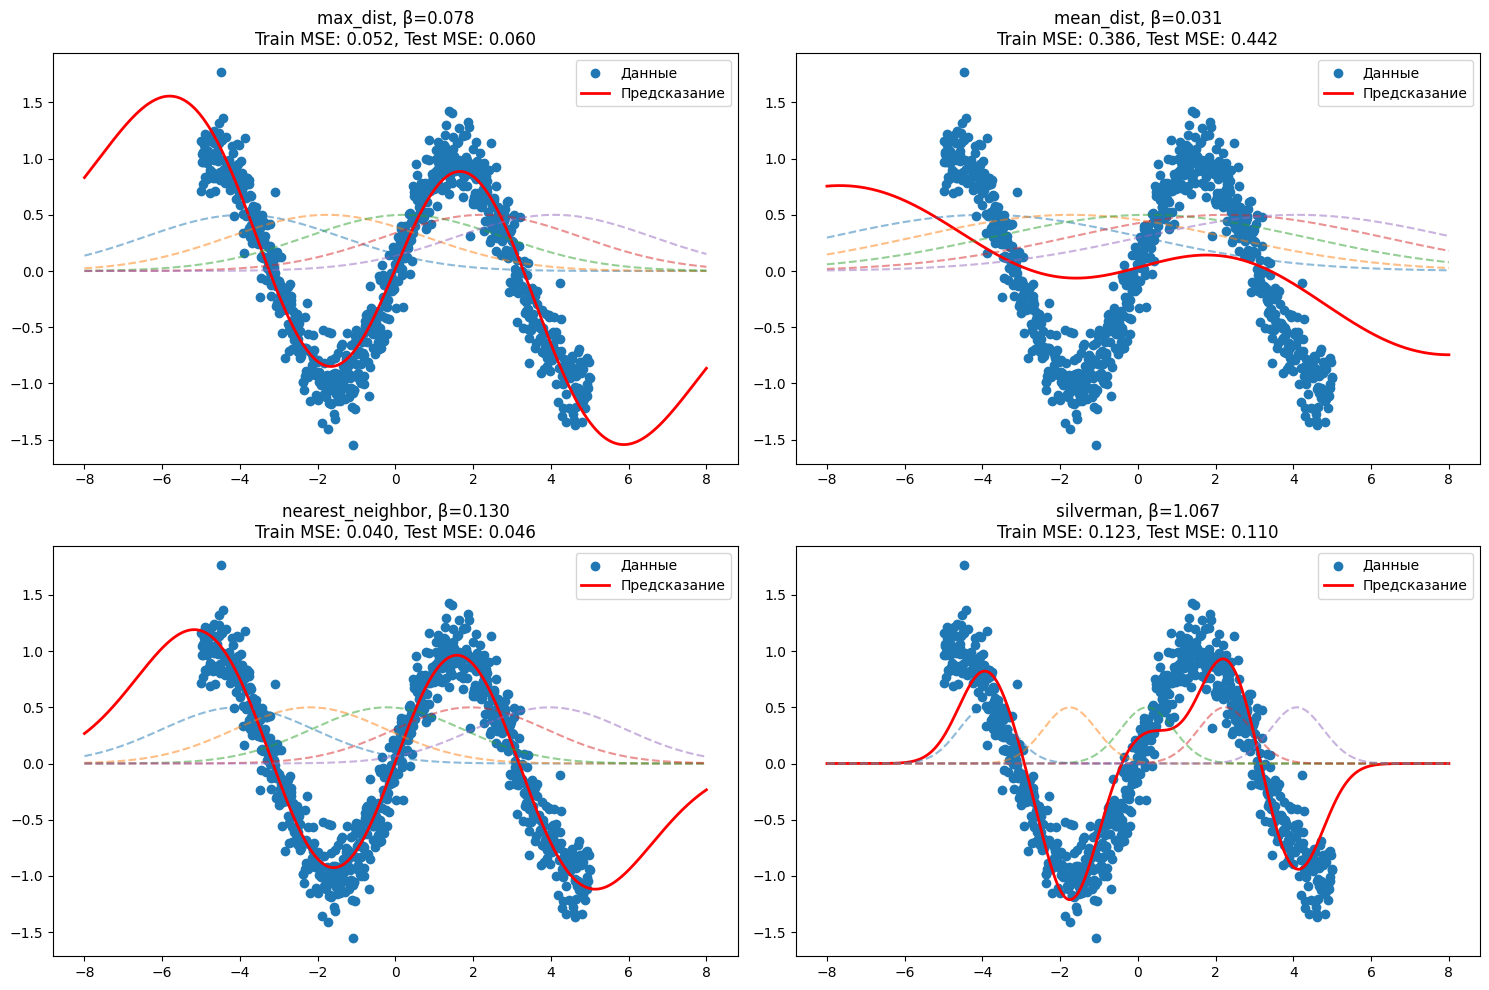

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr

class RBFNetworkBetaMethods(RBFNetwork):
    def __init__(self, num_centers, output_dim, beta_method='kmeans'):
        super().__init__(num_centers, output_dim)
        self.beta_method = beta_method
        self.beta_history = []

    def _calculate_beta(self, X, centers):
        methods = {
            'max_dist': lambda: self._beta_max_dist(centers),
            'mean_dist': lambda: self._beta_mean_dist(centers),
            'nearest_neighbor': lambda: self._beta_nearest_neighbor(centers),
            'silverman': lambda: self._beta_silverman(X)
        }
        return methods[self.beta_method]()

    def _beta_max_dist(self, centers):
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in centers for c2 in centers])
        return 1 / (2 * (d_max / np.sqrt(2 * self.num_centers)) ** 2)

    def _beta_mean_dist(self, centers):
        distances = []
        for i in range(self.num_centers):
            for j in range(i+1, self.num_centers):
                distances.append(np.linalg.norm(centers[i] - centers[j]))
        return 1 / (2 * np.mean(distances) ** 2)

    def _beta_nearest_neighbor(self, centers):
        nbrs = NearestNeighbors(n_neighbors=2).fit(centers)
        distances, _ = nbrs.kneighbors(centers)
        return 1 / (2 * np.mean(distances[:,1]) ** 2)

    def _beta_silverman(self, X):
        sigma = 0.9 * min(np.std(X), iqr(X)/1.34) * len(X) ** (-0.2)
        return 1 / (2 * sigma**2)

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        self.centers = np.sort(self.centers, axis=0)

        self.beta = self._calculate_beta(X, self.centers)
        self.beta_history.append(self.beta)

        self.weights = np.random.randn(self.num_centers, self.output_dim)

        for epoch in tqdm(range(epochs)):
            for i in range(X.shape[0]):
                rbf_outputs = np.array([self._rbf_kernel(X[i], c) for c in self.centers])
                output = rbf_outputs.dot(self.weights)
                error = y[i] - output
                self.weights += learning_rate * error * rbf_outputs.reshape(-1, 1)
            self.log_data.append({
                'epoch': epoch + 1,
                'weights': self.weights.copy().flatten()
            })

methods = ['max_dist', 'mean_dist', 'nearest_neighbor', 'silverman']
results = []
plt.figure(figsize=(15, 10))

for idx, method in enumerate(methods, 1):
    model = RBFNetworkBetaMethods(num_centers=5, output_dim=1, beta_method=method)
    model.fit(X_train, y_train, epochs=200)
    x_plot = np.linspace(-8, 8, 1000).reshape(-1,1)
    y_pred = model.predict(x_plot)
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    results.append({'method': method, 'train': train_mse, 'test': test_mse})
    plt.subplot(2, 2, idx)
    plt.scatter(X_train, y_train, label='Данные')
    plt.plot(x_plot, y_pred, 'r-', lw=2, label='Предсказание')
    for c in model.centers:
        activation = np.exp(-model.beta * (x_plot - c) ** 2)
        plt.plot(x_plot, 0.5 * activation, '--', alpha=0.5)
    plt.title(f'{method}, β={model.beta:.3f}\nTrain MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 200/200 [00:12<00:00, 15.99it/s]


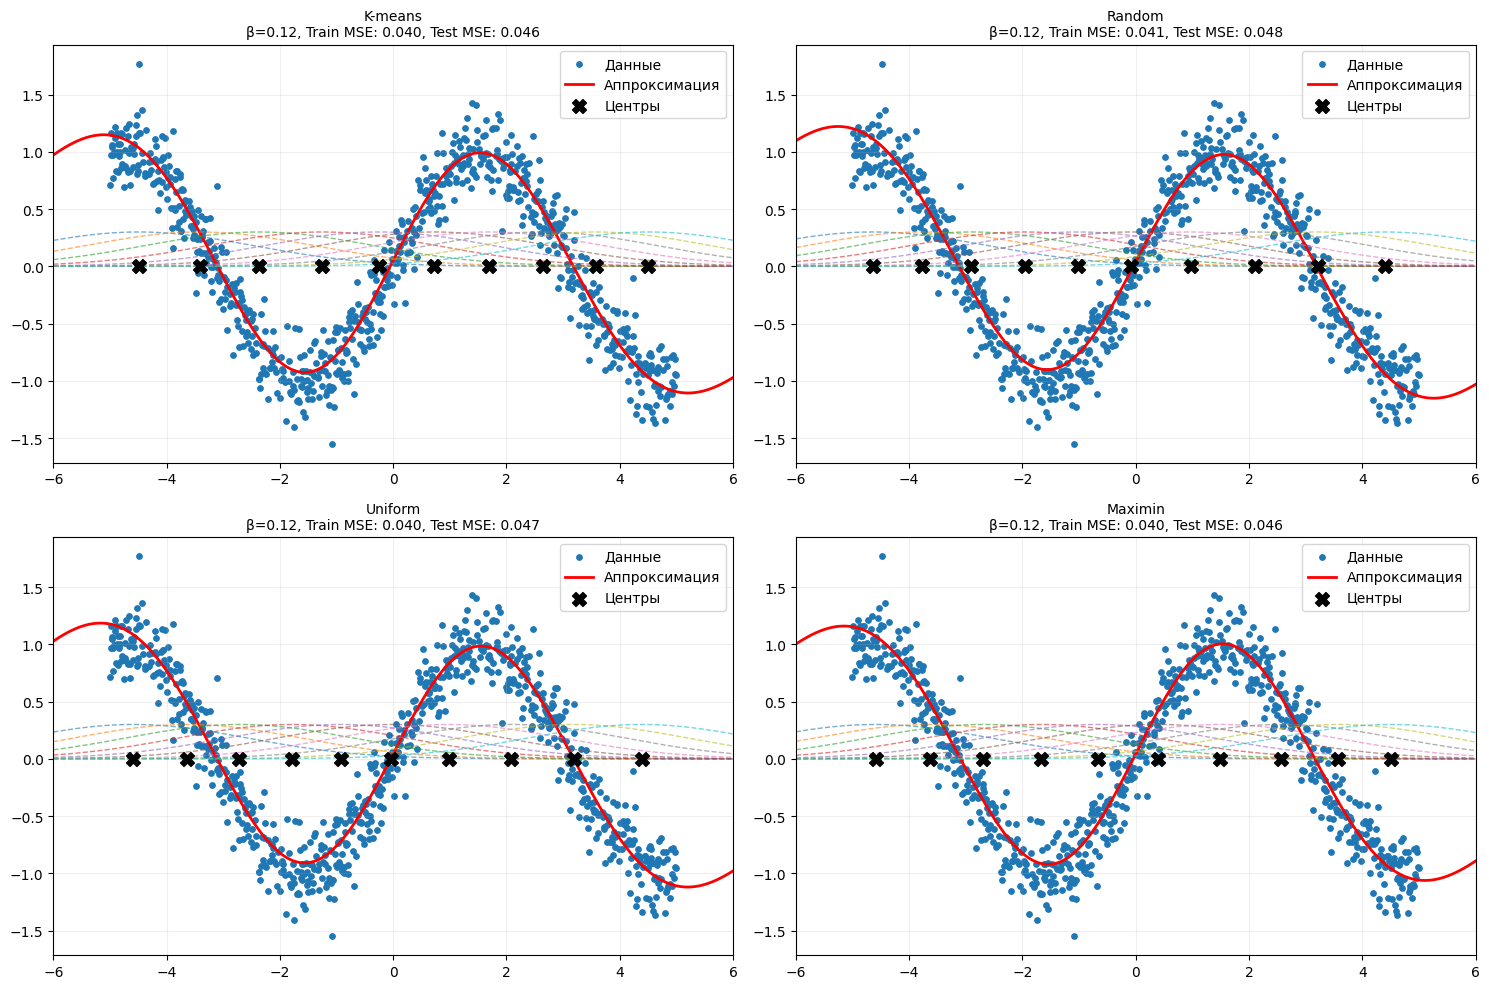

In [ ]:
import time

class RBFNetworkCentersMethods(RBFNetwork):
    def __init__(self, num_centers, output_dim, init_method='kmeans'):
        super().__init__(num_centers, output_dim)
        self.init_method = init_method

    def _init_centers(self, X):
        if self.init_method == 'kmeans':
            self._init_centers_kmeans(X)
        elif self.init_method == 'random':
            self._init_centers_random(X)
        elif self.init_method == 'uniform':
            self._init_centers_uniform(X)
        elif self.init_method == 'maximin':
            self._init_centers_maximin(X)
        else:
            raise ValueError(f"Неизвестный метод инициализации: {self.init_method}")

    def _init_centers_kmeans(self, X):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

    def _init_centers_random(self, X):
        random_indices = np.random.choice(X.shape[0], self.num_centers, replace=False)
        self.centers = X[random_indices]

    def _init_centers_uniform(self, X):
        self.centers = np.linspace(X.min(), X.max(), self.num_centers).reshape(-1, 1)

    def _init_centers_maximin(self, X):
        self.centers = [X[np.random.randint(X.shape[0])]]
        for i in range(self.num_centers - 1):
            D = np.array([np.min([np.linalg.norm(x - c) for c in self.centers]) for x in X])
            self.centers.append(X[np.argmax(D)])
        self.centers = np.array(self.centers)

methods = {
    'K-means': RBFNetworkCentersMethods(num_centers=num_centers, output_dim=1, init_method='kmeans'),
    'Random': RBFNetworkCentersMethods(num_centers=num_centers, output_dim=1, init_method='random'),
    'Uniform': RBFNetworkCentersMethods(num_centers=num_centers, output_dim=1, init_method='uniform'),
    'Maximin': RBFNetworkCentersMethods(num_centers=num_centers, output_dim=1, init_method='maximin')
}

results = []
for name, model in methods.items():
    start_time = time.time()
    model.fit(X_train, y_train, epochs=200)
    results.append({
        'method': name,
        'time': time.time() - start_time,
        'train_mse': mean_squared_error(y_train, model.predict(X_train)),
        'test_mse': mean_squared_error(y_test, model.predict(X_test)),
        'centers': model.centers.copy()
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(15, 10))
x_plot = np.linspace(X_train.min()-1, X_train.max()+1, 1000).reshape(-1,1)

for i, (method, res) in enumerate(zip(results_df['method'], results_df.iterrows()), 1):
    plt.subplot(2, 2, i)
    model = methods[method]
    y_pred = model.predict(x_plot)
    plt.scatter(X_train, y_train, s=15, label='Данные')
    plt.plot(x_plot, y_pred, 'r-', lw=2, label='Аппроксимация')
    for c in model.centers:
        activation = np.exp(-model.beta * (x_plot - c) ** 2)
        plt.plot(x_plot, 0.3*activation, '--', alpha=0.6, lw=1)
    plt.scatter(res[1]['centers'], np.zeros_like(res[1]['centers']), marker='X', s=100, color='black', label='Центры', zorder=3)
    plt.title(f"{method}\nβ={model.beta:.2f}, Train MSE: {res[1]['train_mse']:.3f}, Test MSE: {res[1]['test_mse']:.3f}", fontsize=10)
    plt.grid(alpha=0.2)
    plt.legend(loc='upper right')
    plt.xlim(x_plot.min(), x_plot.max())

plt.tight_layout()
plt.show()

100%|██████████| 200/200 [00:12<00:00, 15.75it/s]


Optimal beta by train: 0.3039195382313198
Best train MSE: 0.038043019869056574
Best test MSE: 0.04206247529712954


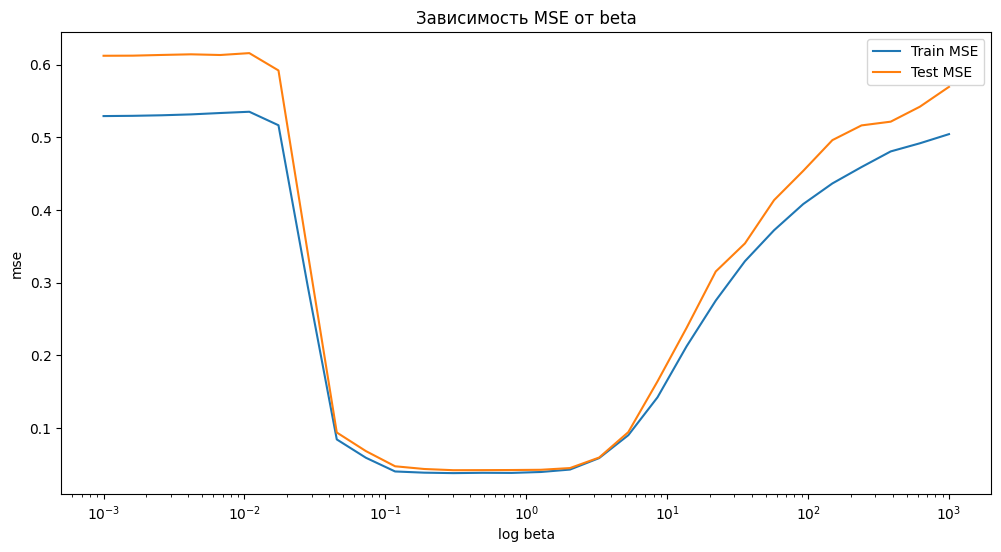

In [ ]:
class RBFNetworkBeta(RBFNetwork):
    def __init__(self, num_centers, output_dim, beta=None):
        super().__init__(num_centers, output_dim)
        self.beta = beta

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        self.centers = np.sort(kmeans.cluster_centers_, axis=0)

        self.weights = np.random.randn(self.num_centers, self.output_dim)

        for epoch in tqdm(range(epochs)):
            for i in range(X.shape[0]):
                rbf_outputs = np.array([self._rbf_kernel(X[i], c) for c in self.centers])
                output = rbf_outputs.dot(self.weights)
                error = y[i] - output
                self.weights += learning_rate * error * rbf_outputs.reshape(-1, 1)

beta_values = np.logspace(-3, 3, 30)
train_errors = []
test_errors = []

for beta in beta_values:
    model = RBFNetworkBeta(num_centers=num_centers, output_dim=1, beta=beta)
    model.fit(X_train, y_train, epochs=200)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(12, 6))
plt.semilogx(beta_values, train_errors, label='Train MSE')
plt.semilogx(beta_values, test_errors, label='Test MSE')
plt.title('Зависимость MSE от beta')
plt.xlabel('log beta')
plt.ylabel('mse')
plt.legend()
opt_idx = np.argmin(train_errors)
print('Optimal beta by train:', beta_values[opt_idx])
print('Best train MSE:', train_errors[opt_idx])
print('Best test MSE:', test_errors[opt_idx])
plt.show()

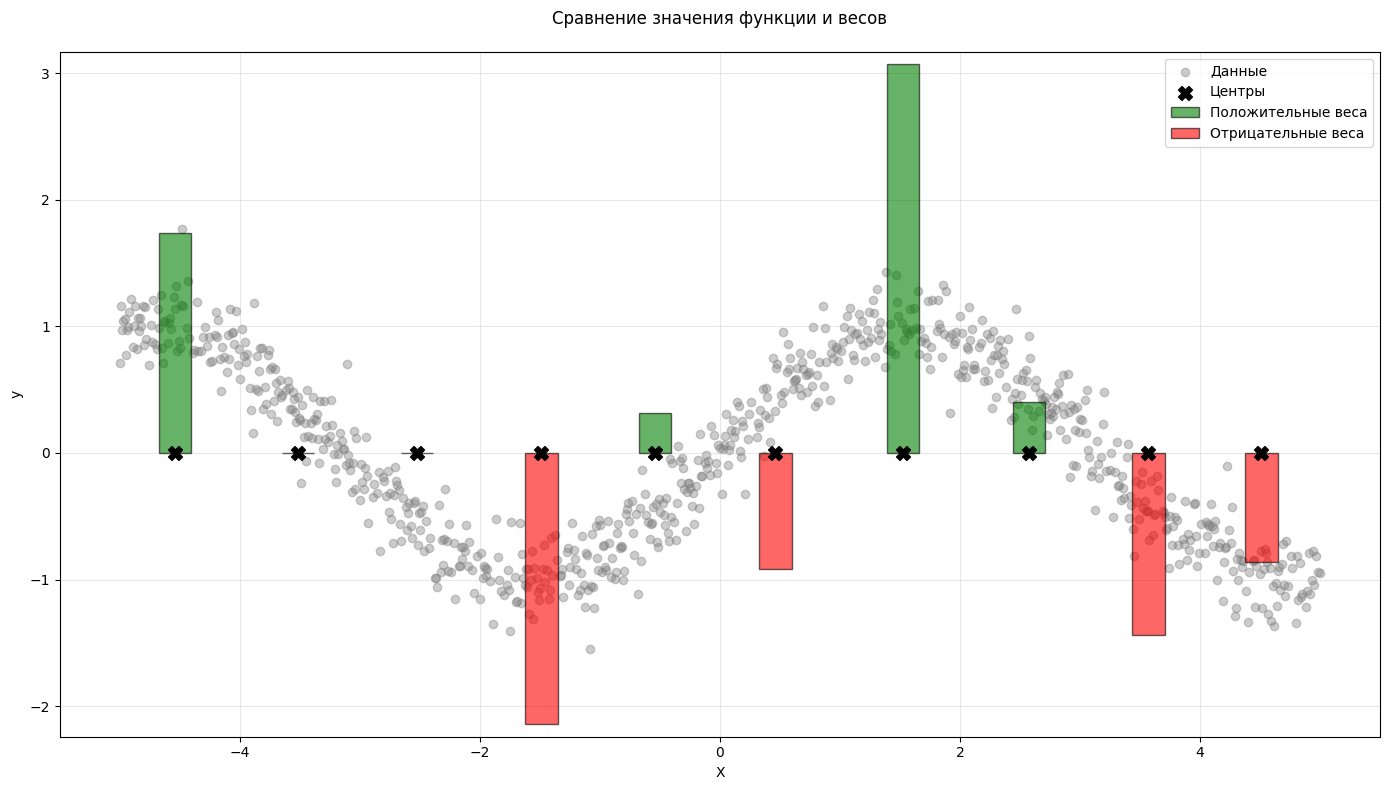

In [ ]:
def visualize_model(rbf_net, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(14, 8))
    plt.scatter(X_train, y_train, c='grey', alpha=0.4, label='Данные')
    centers = rbf_net.centers.flatten()
    weights = rbf_net.weights.flatten()
    bar_width = 0.3 * (np.max(centers) - np.min(centers))/len(centers)
    for i, (c, w) in enumerate(zip(centers, weights)):
        color = 'red' if w < 0 else 'green'
        label = 'Отрицательные веса' if w < 0 else 'Положительные веса' if i == 0 else None
        plt.bar(c, height=w,
                width=bar_width,
                bottom=0,
                color=color,
                alpha=0.6,
                edgecolor='black',
                zorder=2,
                label=label)
    plt.scatter(centers, np.zeros_like(centers),
                c='black',
                marker='X',
                s=100,
                label='Центры',
                zorder=3)
    y_min = min(np.min(y_train), np.min(weights)) - 0.1
    y_max = max(np.max(y_train), np.max(weights)) + 0.1
    plt.ylim(y_min, y_max)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
    plt.title('Сравнение значения функции и весов', pad=20)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_model(rbf_net, X_train, y_train, X_test, y_test)

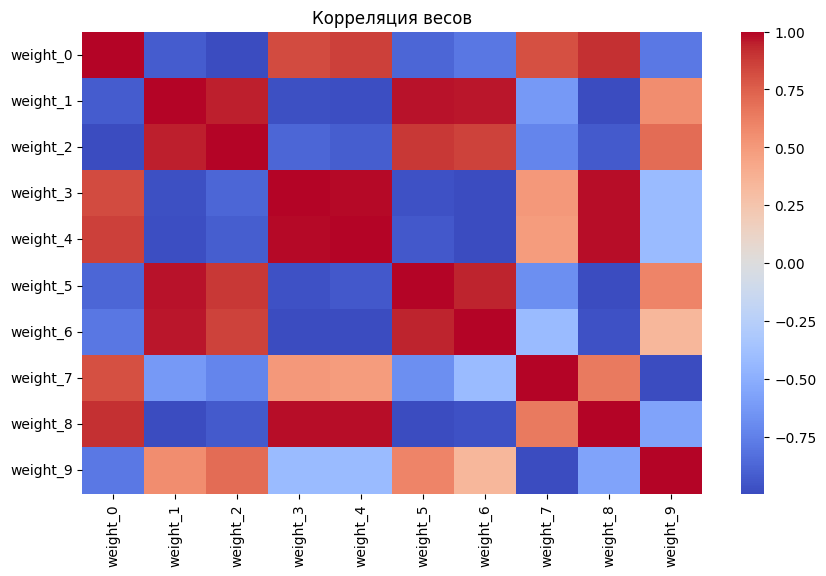

In [ ]:
import seaborn as sns

weights = pd.read_csv("weights_log.csv").filter(regex='weight')
plt.figure(figsize=(10,6))
sns.heatmap(weights.corr(), cmap='coolwarm', center=0)
plt.title("Корреляция весов")
plt.show()

In [ ]:
from ipywidgets import interact, IntSlider

df = pd.read_csv("weights_log.csv")
weight_cols = [col for col in df.columns if 'weight' in col]
max_epoch = df['epoch'].max()

def update_heatmap(epoch):
    plt.figure(figsize=(12, 8))
    current_data = df[df['epoch'] <= epoch][weight_cols]
    if len(current_data) < 2:
        plt.text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
    else:
        corr_matrix = current_data.corr()
        sns.heatmap(
            corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 8},
            linewidths=0.5
        )
    plt.title(f"Корреляция весов между центрами RBF (накоплено эпох: {epoch})\n")
    plt.tight_layout()
    plt.show()
interact(
    update_heatmap,
    epoch=IntSlider(
        value=1,
        min=1,
        max=max_epoch,
        step=1,
        description='Эпоха:',
        continuous_update=False,
        layout={'width': '500px'}
    )
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Эпоха:', layout=Layout(width='5…

<function __main__.update_heatmap(epoch)>

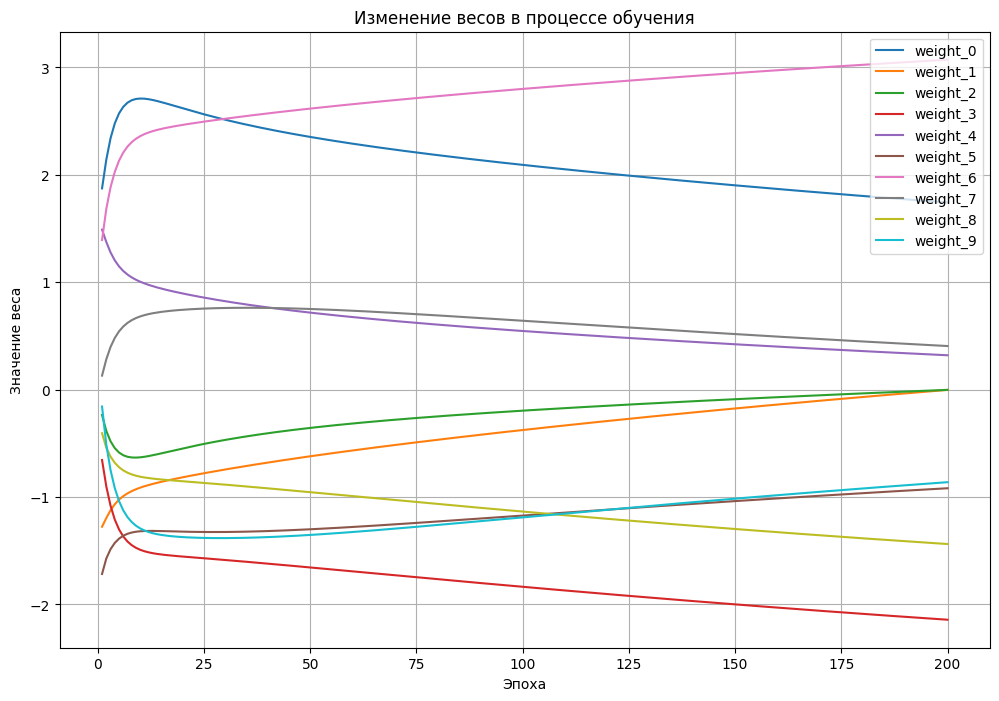

In [ ]:
log_df = pd.read_csv("weights_log.csv")
log_df = log_df.sort_values(by=['epoch'])
plt.figure(figsize=(12, 8))
weight_columns = [col for col in log_df.columns if col.startswith('weight_')]
for col in weight_columns:
    plt.plot(log_df['epoch'], log_df[col], label=col)
plt.title('Изменение весов в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение веса')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

<ipython-input-17-bd3864751692>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


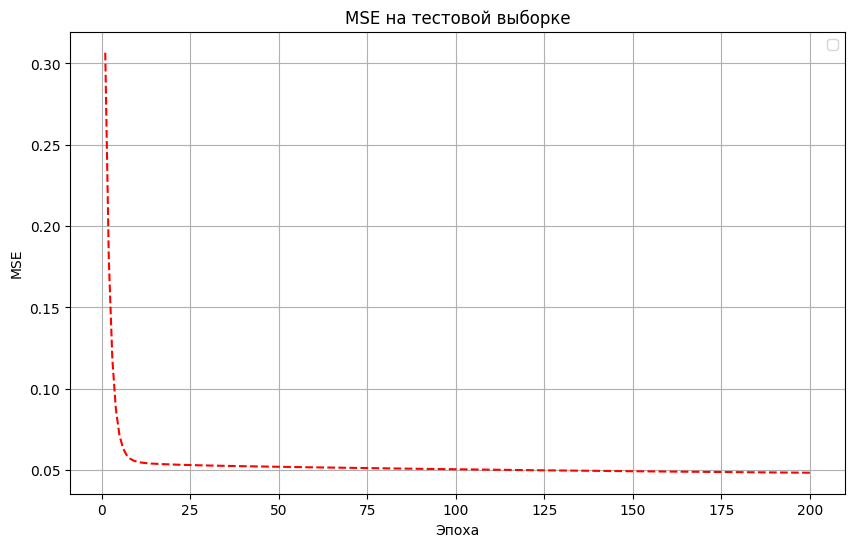

In [ ]:
log_df = pd.read_csv("weights_log.csv")
mse_history = []
for epoch, row in log_df.iterrows():
    weights = row.filter(regex='weight_').values.reshape(-1, 1)
    rbf_net.weights = weights.copy()
    y_pred = rbf_net.predict(X_test)
    current_mse = mean_squared_error(y_test, y_pred)
    mse_history.append(current_mse)

plt.figure(figsize=(10, 6))
plt.plot(log_df['epoch'], mse_history, 'r--', linewidth=1.5)
plt.title('MSE на тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
rbf_net.weights = log_df.filter(regex='weight_').iloc[-1].values.reshape(-1, 1)
plt.show()

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


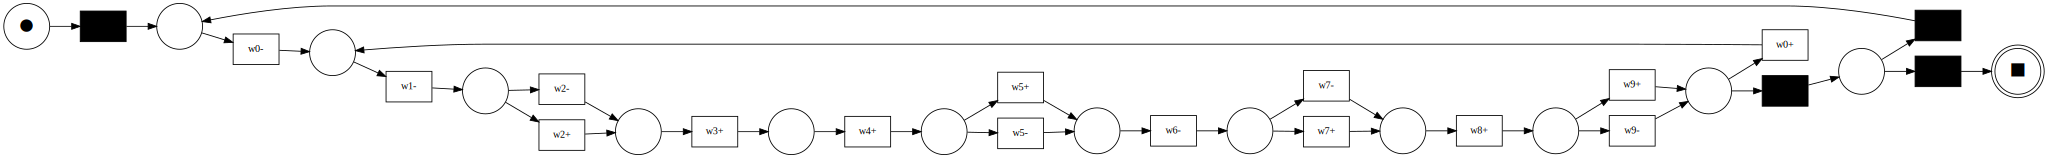

In [ ]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from IPython.display import SVG

weights_df = pd.read_csv("weights_log.csv").sort_values('epoch')

events = []
prev_weights = None
for idx, row in weights_df.iterrows():
    if idx > 50:
      continue
    if prev_weights is not None:
        for i in range(num_centers):
            curr_w = row[f'weight_{i}']
            prev_w = prev_weights[i]
            if curr_w > prev_w:
                event = f"w{i}-"
            else:
                event = f"w{i}+"
            events.append({
                'case:concept:name': 'training',
                'concept:name': event,
                'time:timestamp': pd.Timestamp(2023, 1, 1) + pd.Timedelta(row['epoch'], 'D')
            })
    prev_weights = row[[f'weight_{i}' for i in range(num_centers)]].values

event_log = log_converter.apply(pd.DataFrame(events))
net, im, fm = pm4py.discover_petri_net_inductive(event_log)
pm4py.save_vis_petri_net(net, im, fm, "weights_process.svg")
SVG("weights_process.svg")

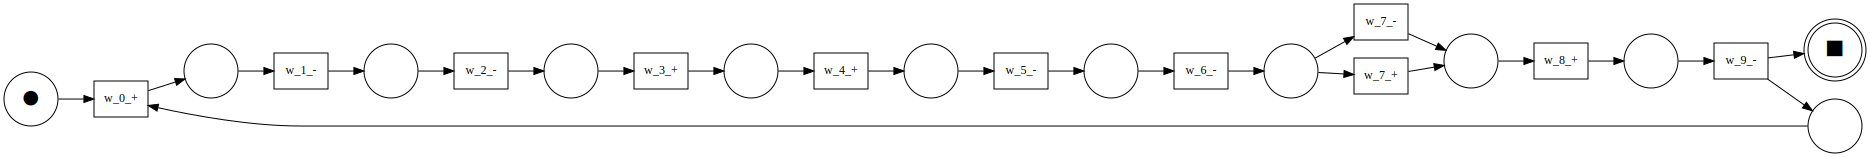

In [ ]:
weights_df = pd.read_csv("weights_log.csv").sort_values('epoch')
num_centers = len([col for col in weights_df.columns if col.startswith('weight_')])

events = []
prev_weights = None
for idx, row in weights_df.iterrows():
    if idx < 30:
      continue
    if prev_weights is not None:
        for i in range(num_centers):
            curr_w = row[f'weight_{i}']
            prev_w = prev_weights[i]
            event = f"w_{i}_-" if curr_w > prev_w else f"w_{i}_+"
            events.append({
                'case:concept:name': 'training',
                'concept:name': event,
                'time:timestamp': pd.Timestamp(2023, 1, 1) + pd.Timedelta(row['epoch'], 'D')
            })
    prev_weights = row[[f'weight_{i}' for i in range(num_centers)]].values

event_log = log_converter.apply(pd.DataFrame(events))
net, im, fm = pm4py.discover_petri_net_alpha(event_log)
pm4py.save_vis_petri_net(net, im, fm, "weights_process_alpha.svg")
SVG("weights_process_alpha.svg")

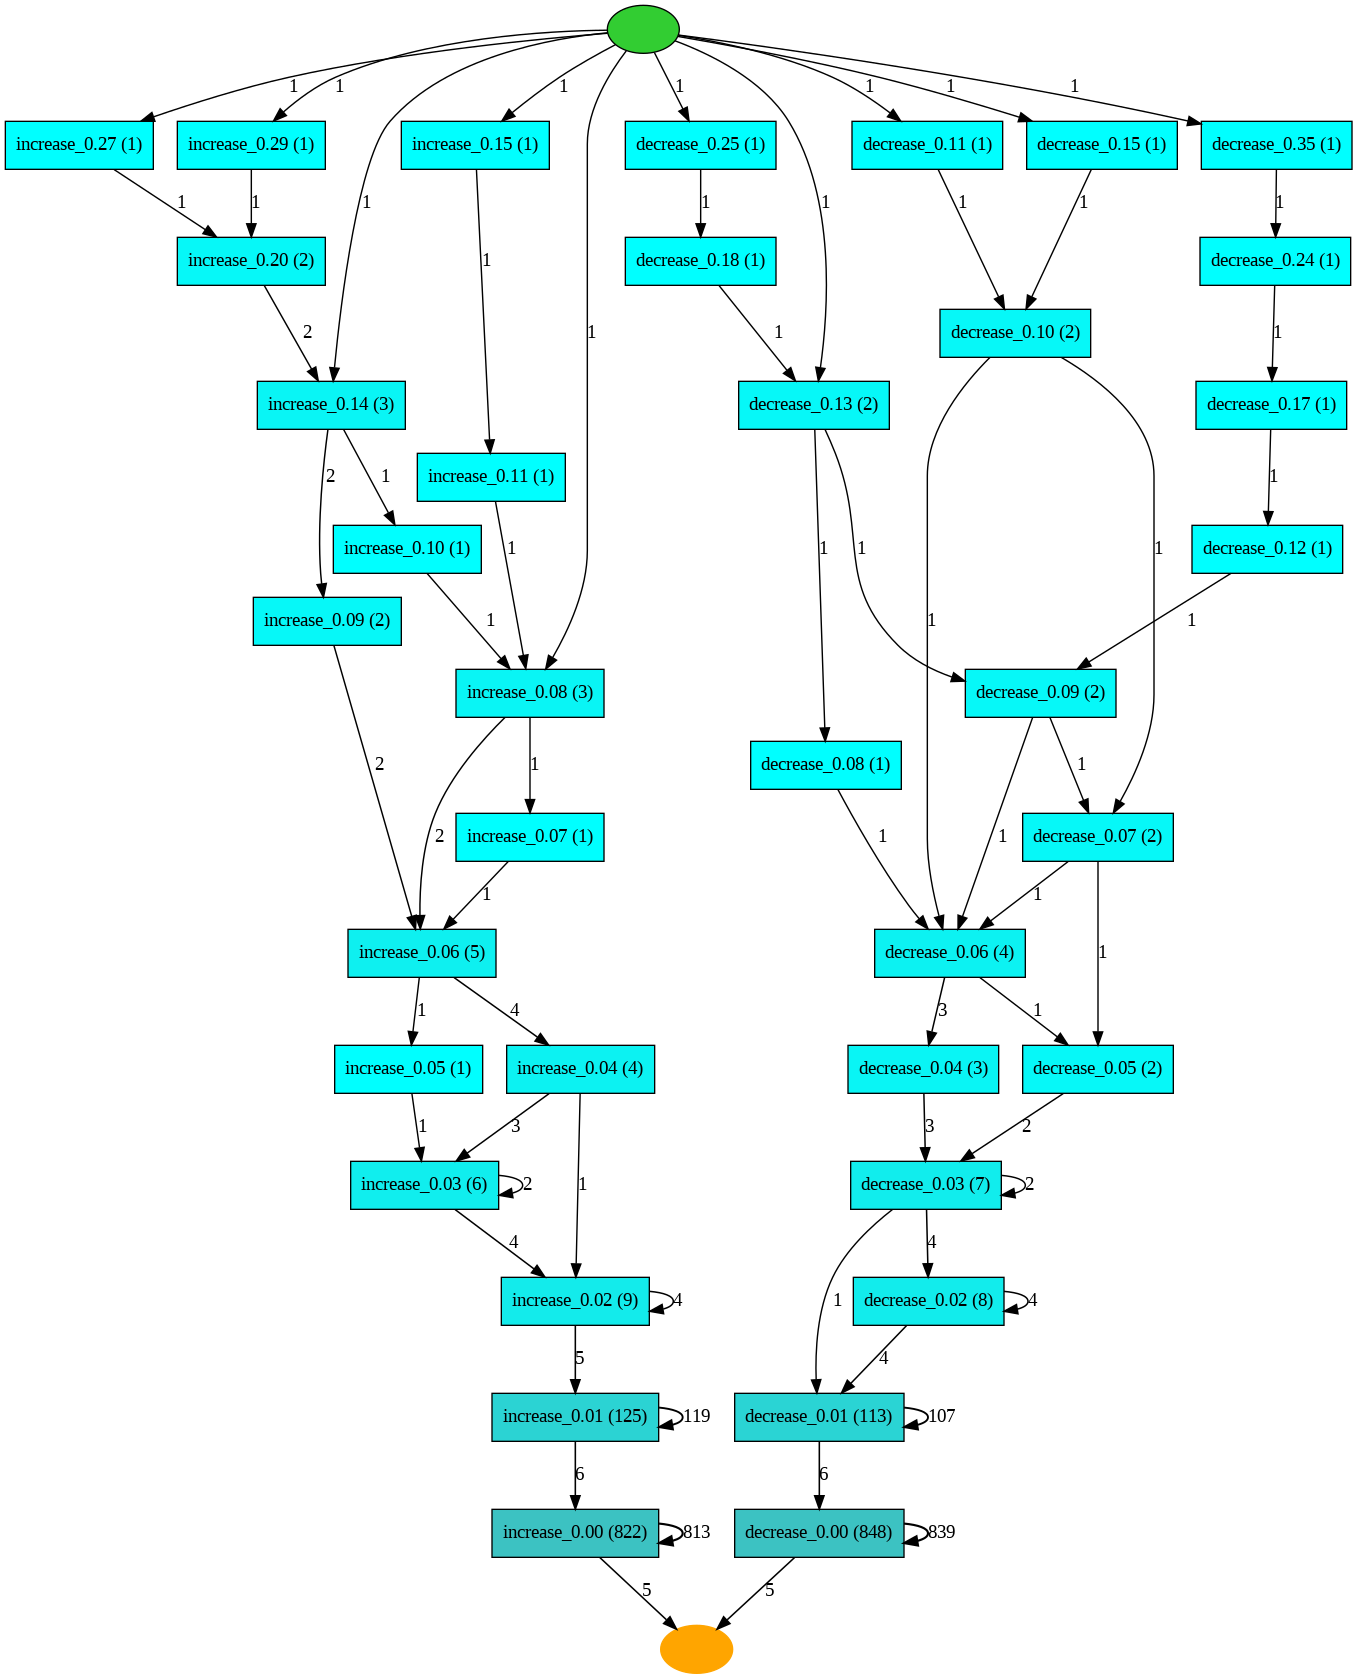

In [ ]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

weights_df = pd.read_csv("weights_log.csv").sort_values('epoch')
num_centers = len([col for col in weights_df.columns if col.startswith('weight_')])

events = []
for epoch, row in weights_df.iterrows():
    if epoch == 0:
        continue
    prev_row = weights_df.iloc[epoch-1]
    for i in range(num_centers):
        delta = row[f'weight_{i}'] - prev_row[f'weight_{i}']
        event_type = "increase" if delta > 0 else "decrease"
        events.append({
            'case:concept:name': f'Weight_{i}', #Попробовать эпоху
            'concept:name': f"{event_type}_{abs(delta):.2f}",
            'time:timestamp': pd.Timestamp.now() + pd.Timedelta(epoch, 'h')
        })

event_log = log_converter.apply(pd.DataFrame(events))
heu_net = heuristics_miner.apply_heu(event_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

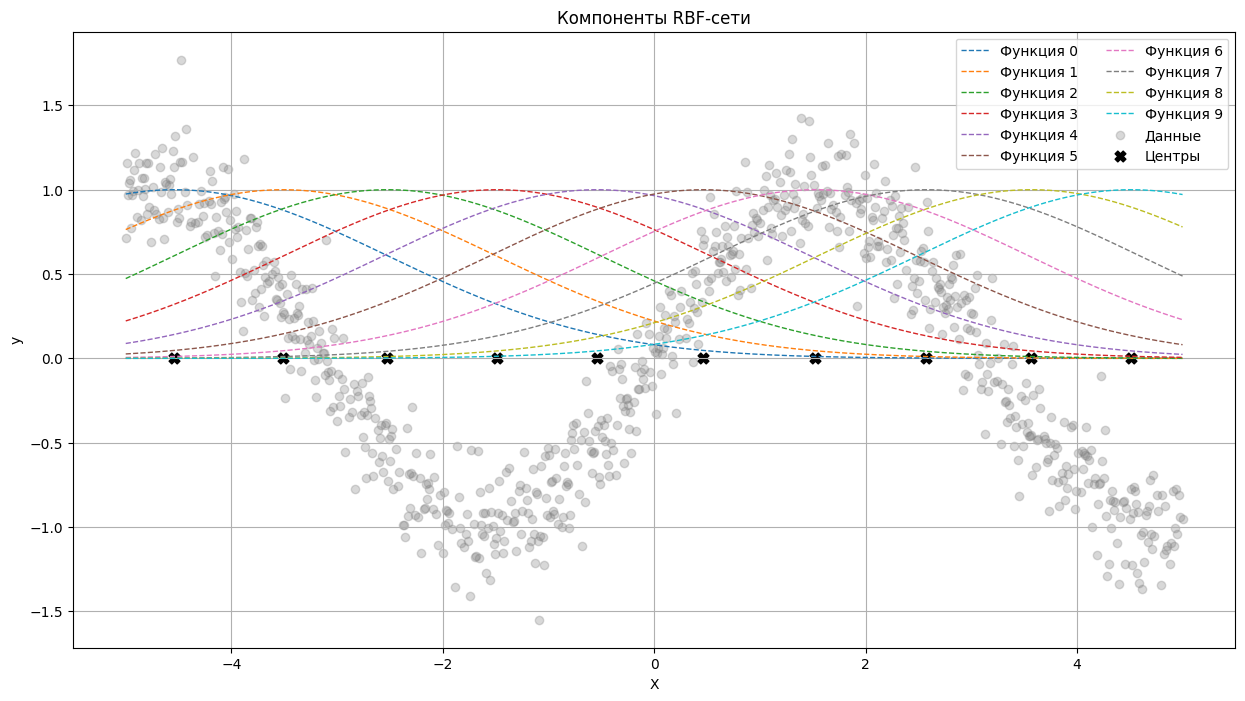

In [ ]:
def plot_components(model, X, y, n_points=1000):
    plt.figure(figsize=(15, 8))
    x_plot = np.linspace(X.min(), X.max(), n_points).reshape(-1, 1)
    distances = np.abs(x_plot - model.centers.T)
    activations = np.exp(-model.beta * distances ** 2)
    components = activations
    for i in range(components.shape[1]):
        plt.plot(x_plot, components[:, i],
                 linestyle='--',
                 linewidth=1,
                 label=f'Функция {i}' )
    plt.scatter(X, y, c='gray', alpha=0.3, label='Данные')
    plt.scatter(model.centers, np.zeros_like(model.centers),
                c='black', s=60, marker='X', label='Центры')

    plt.title('Компоненты RBF-сети')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.show()

plot_components(rbf_net, X_train, y_train)

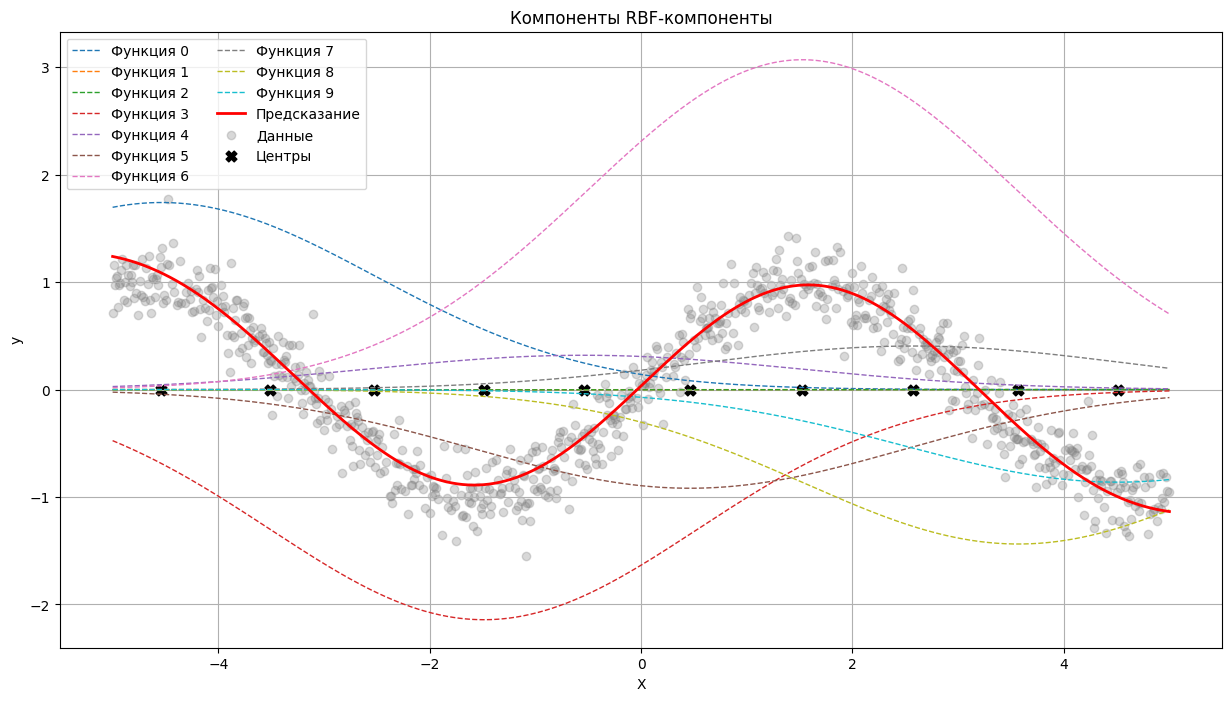

In [ ]:
def plot_components(model, X, y, n_points=1000):
    plt.figure(figsize=(15, 8))
    x_plot = np.linspace(X.min(), X.max(), n_points).reshape(-1, 1)
    distances = np.abs(x_plot - model.centers.T)
    activations = np.exp(-model.beta * distances ** 2)
    components = activations * model.weights.T
    for i in range(components.shape[1]):
        plt.plot(x_plot, components[:, i],
                 linestyle='--',
                 linewidth=1,
                 label=f'Функция {i}' )
    prediction = components.sum(axis=1)
    plt.plot(x_plot, prediction, 'r-', linewidth=2, label='Предсказание')
    plt.scatter(X, y, c='gray', alpha=0.3, label='Данные')
    plt.scatter(model.centers, np.zeros_like(model.centers), c='black', s=60, marker='X', label='Центры')
    plt.title('Компоненты RBF-компоненты')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.show()

plot_components(rbf_net, X_train, y_train)

##Не используется

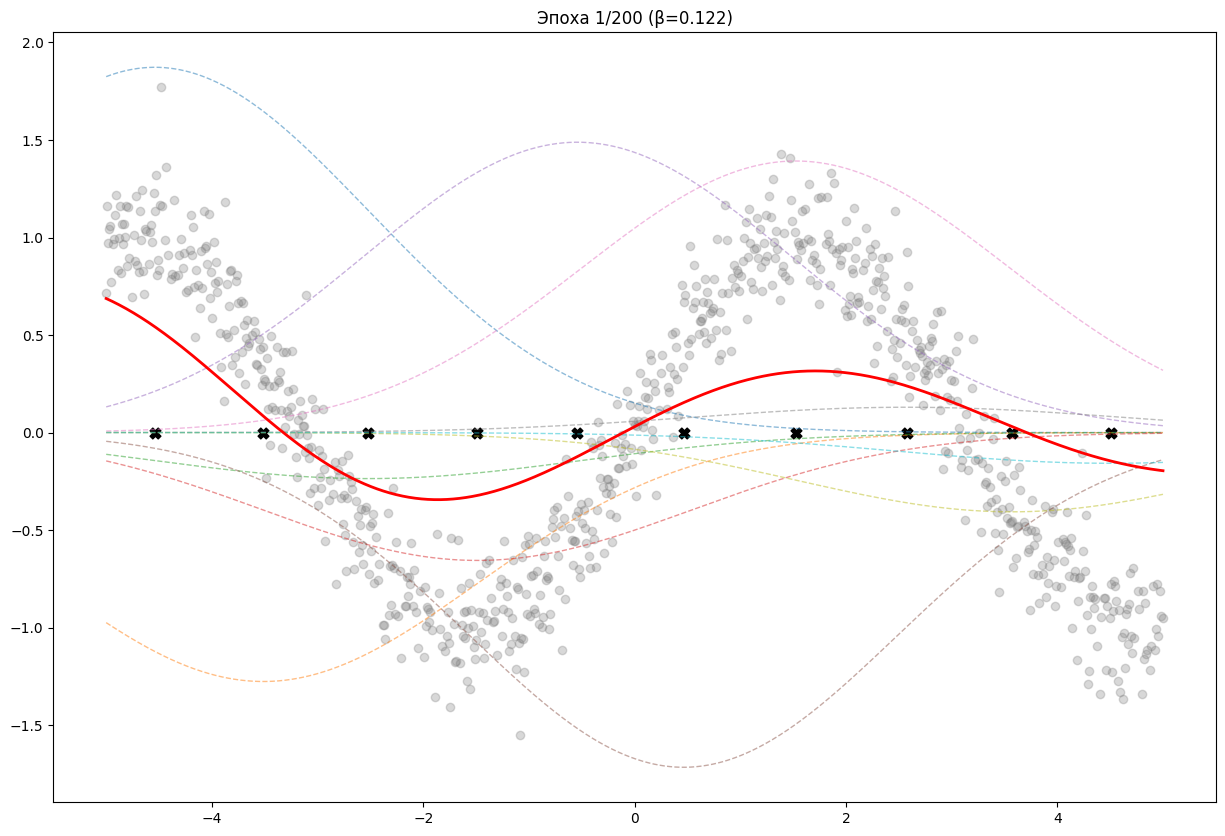

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

def create_interactive_plot(model, X, y, log_file="weights_log.csv"):
    weights_log = pd.read_csv(log_file)
    epoch_list = weights_log['epoch'].values
    weights_history = weights_log.drop(columns='epoch').values.reshape(len(epoch_list), -1, 1)
    fig, ax = plt.subplots(figsize=(15, 10))
    x_plot = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    centers = model.centers.reshape(1, -1)
    sum_line, = ax.plot([], [], 'r-', lw=2)
    component_lines = [ax.plot([], [], '--', lw=1, alpha=0.5)[0] for _ in range(model.num_centers)]
    ax.scatter(X, y, c='gray', alpha=0.3)
    ax.scatter(centers.T, np.zeros_like(centers.T), c='black', s=60, marker='X')
    ax.set(xlim=(X.min(), X.max()),
           ylim=(y.min()-3, y.max()+5),
           xlabel='X',
           ylabel='y')
    out = widgets.Output()
    slider = IntSlider(min=0, max=len(epoch_list)-1, value=0, description='Эпоха:')
    def update(change=None, epoch_idx=0):
        ax.clear()
        if change is not None:
            epoch_idx = change.new
        current_weights = weights_history[epoch_idx]
        distances = np.abs(x_plot - centers)
        activations = np.exp(-model.beta * distances**2)
        components = activations * current_weights.T
        ax.scatter(X, y, c='gray', alpha=0.3)
        ax.scatter(centers.T, np.zeros_like(centers.T), c='black', s=60, marker='X')
        for i in range(model.num_centers):
            ax.plot(x_plot, components[:, i], '--', lw=1, alpha=0.5)
        ax.plot(x_plot, components.sum(axis=1), 'r-', lw=2)
        ax.set_title(f'Эпоха {epoch_idx+1}/{len(epoch_list)} (β={model.beta:.3f})')
        with out:
            clear_output(wait=True)
            display(fig)
    update(epoch_idx=0)
    slider.observe(update, names='value')
    display(widgets.VBox([slider, out]))

create_interactive_plot(rbf_net, X_train, y_train)

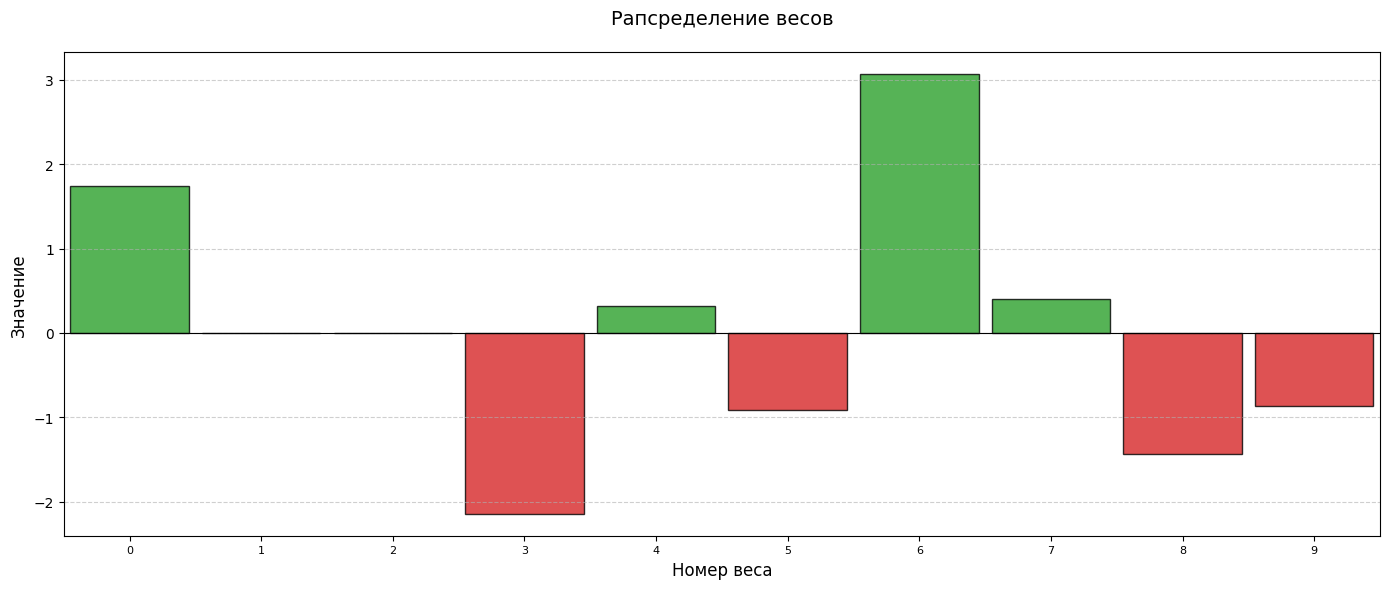

In [ ]:
plt.figure(figsize=(14, 6))
weights = rbf_net.weights.flatten()
indices = np.arange(len(weights))
colors = ['tab:green' if w >= 0 else 'tab:red' for w in weights]
bars = plt.bar(indices, weights,
             color=colors,
             edgecolor='black',
             alpha=0.8,
             width=0.9)
plt.title('Рапсределение весов', fontsize=14, pad=20)
plt.xlabel('Номер веса', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(indices, fontsize=8)
plt.xlim(-0.5, len(weights)-0.5)
plt.axhline(0, color='black', linewidth=0.8)
plt.gca().tick_params(axis='x', rotation=45 if len(weights) > 30 else 0)
plt.tight_layout()
plt.show()

100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


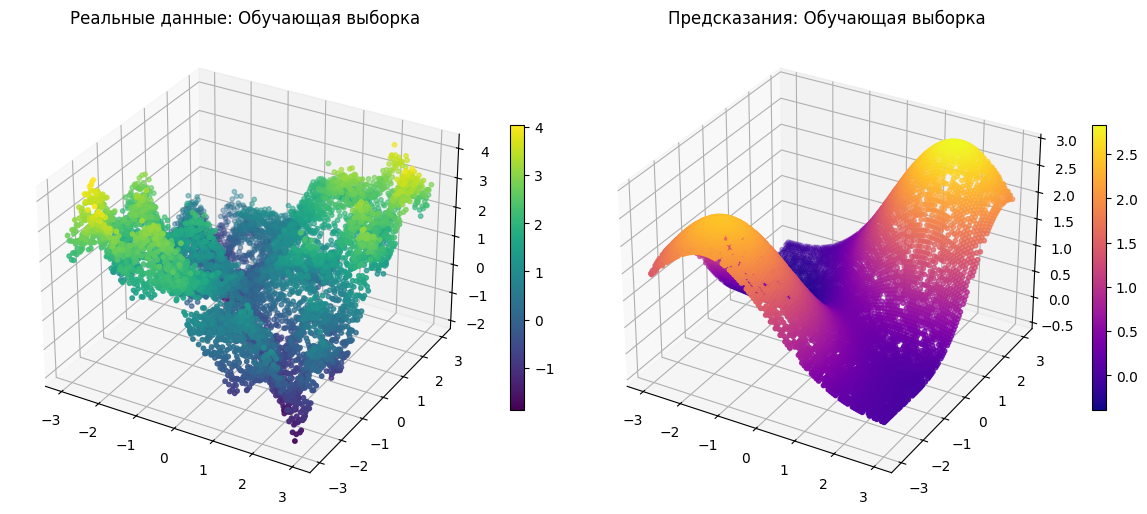

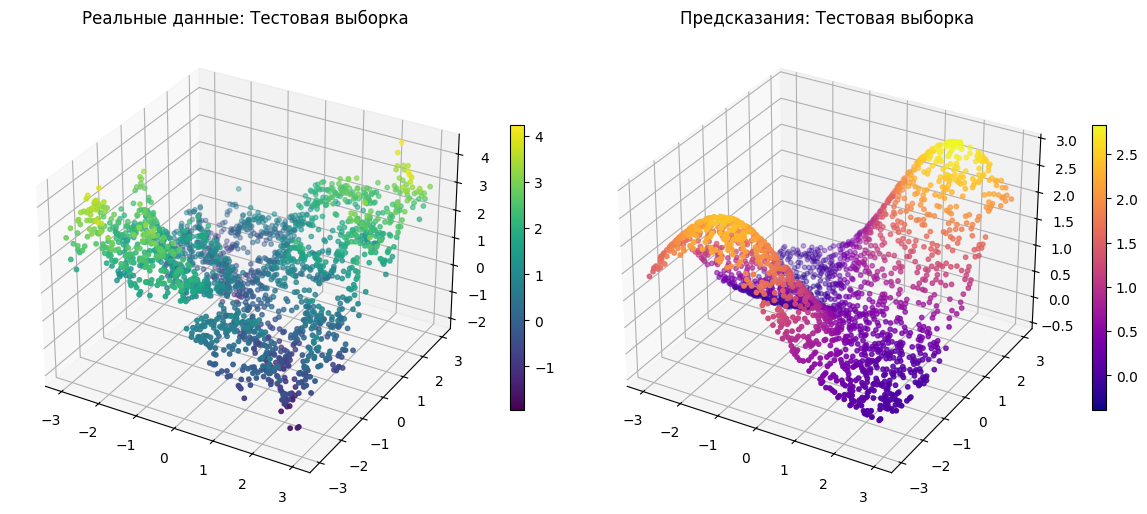

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def complex_function(x1, x2):
    return (np.sin(x1**2) * np.cos(3*x2) +
            0.5 * np.abs(x1 + x2) +
            0.3 * np.sign(x1*x2) * np.sqrt(np.abs(x1 - x2)))
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)
y = complex_function(X[:,0], X[:,1]) + np.random.normal(0, 0.2, X.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_centers = 5
rbf_net = RBFNetwork(num_centers=num_centers, output_dim=1)
rbf_net.fit(X_train, y_train, epochs=200)
rbf_net.save_logs()

def plot_surface(X, y, title):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    sc1 = ax1.scatter(X[:,0], X[:,1], y, c=y, cmap='viridis', s=10)
    ax1.set_title(f'Реальные данные: {title}')

    ax2 = fig.add_subplot(122, projection='3d')
    y_pred = rbf_net.predict(X)
    sc2 = ax2.scatter(X[:,0], X[:,1], y_pred, c=y_pred, cmap='plasma', s=10)
    ax2.set_title(f'Предсказания: {title}')

    plt.colorbar(sc1, ax=ax1, shrink=0.5)
    plt.colorbar(sc2, ax=ax2, shrink=0.5)
    plt.tight_layout()

plot_surface(X_train, y_train, "Обучающая выборка")
plot_surface(X_test, y_test, "Тестовая выборка")
plt.show()

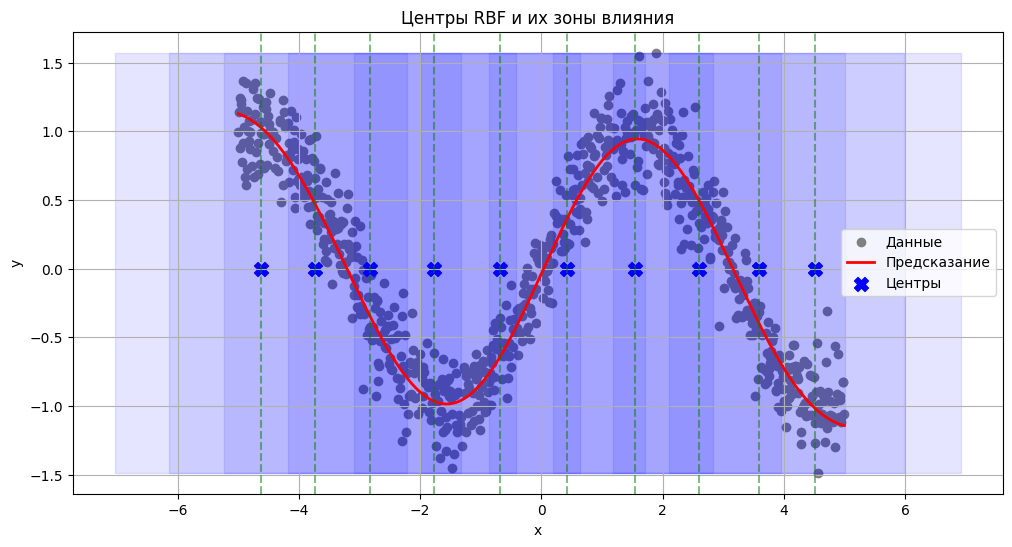

In [ ]:
def plot_centers_1d(model, X, y, threshold=0.5):
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, c='gray', label='Данные')
    x_plot = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    y_pred = model.predict(x_plot)
    plt.plot(x_plot, y_pred, c='red', linewidth=2, label='Предсказание')
    centers = model.centers.ravel()
    plt.scatter(centers, np.zeros_like(centers), c='blue', s=100, marker='X', label='Центры')
    radius = np.sqrt(-np.log(threshold) / model.beta)
    for center in centers:
        plt.axvline(center, color='green', linestyle='--', alpha=0.5)
        plt.fill_betweenx(
            y=[y.min(), y.max()],
            x1=center - radius,
            x2=center + radius,
            color='blue',
            alpha=0.1
        )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Центры RBF и их зоны влияния')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_centers_1d(rbf_net, X_train, y_train, threshold=0.5)

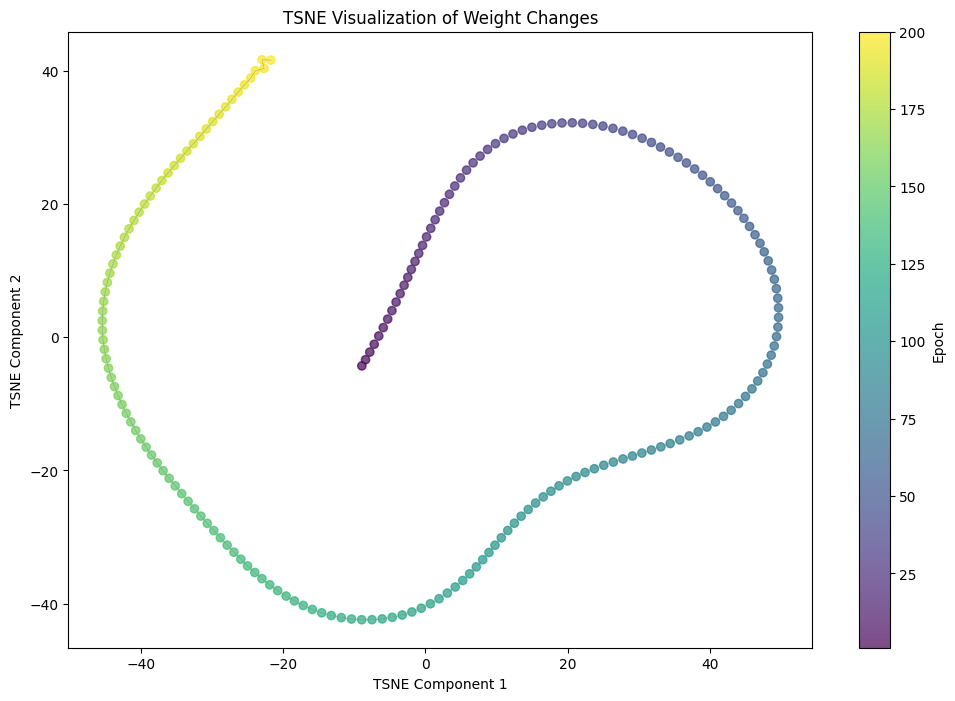

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_weights_tsne(model, filename="weights_tsne.png"):
    weights_data = []
    for log_entry in model.log_data:
        epoch = log_entry["epoch"]
        weights = log_entry["weights"].flatten()
        weights_data.append([epoch] + list(weights))

    df_weights = pd.DataFrame(weights_data)
    epoch_column = df_weights.pop(0)
    df_weights.columns = [f"weight_{i}" for i in range(len(df_weights.columns))]

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    weights_tsne = tsne.fit_transform(df_weights)

    df_tsne = pd.DataFrame(weights_tsne, columns=["tsne_1", "tsne_2"])
    df_tsne["epoch"] = epoch_column
    df_tsne.sort_values(by="epoch", inplace=True)

    plt.figure(figsize=(12, 8))
    plt.plot(df_tsne["tsne_1"], df_tsne["tsne_2"], c="gray", alpha=0.5, linestyle="-", linewidth=0.5)
    plt.scatter(df_tsne["tsne_1"], df_tsne["tsne_2"], c=df_tsne["epoch"], cmap="viridis", alpha=0.7)
    plt.colorbar(label="Epoch")
    plt.title("TSNE Visualization of Weight Changes")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.savefig(filename)
    plt.show()

visualize_weights_tsne(rbf_net)